In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# from keras.preprocessing import timeseries

In [2]:
df = pd.read_csv('data/jena_climate_2009_2016.csv', index_col=None)

In [3]:
df.shape

(420451, 15)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420451.0,989.212508,8.359454,913.60,984.20,989.57,994.72,1015.35
T (degC),420451.0,9.448567,8.423685,-23.01,3.36,9.41,15.47,37.28
Tpot (K),420451.0,283.491182,8.504820,250.60,277.43,283.46,289.53,311.34
Tdew (degC),420451.0,4.954011,6.730411,-25.01,0.24,5.21,10.07,23.11
rh (%),420451.0,76.007045,16.477126,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420451.0,13.575089,7.739481,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420451.0,9.532524,4.183895,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420451.0,4.042483,4.897270,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420451.0,6.021630,2.655973,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420451.0,9.638982,4.235130,0.80,6.29,8.96,12.48,28.82


In [5]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

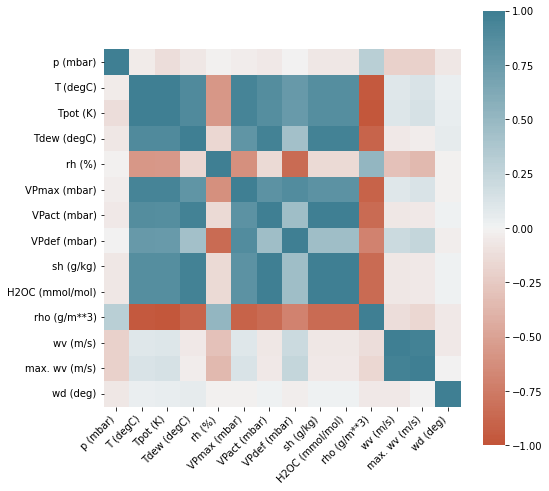

In [6]:
corr = df.corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr, 
                 vmin=-1, 
                 vmax=1, 
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [7]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

<AxesSubplot:>

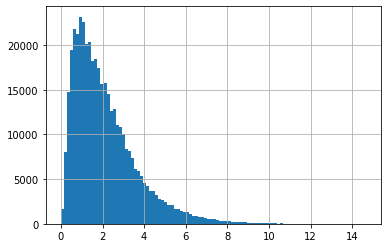

In [8]:
df['wv (m/s)'].hist(bins=100)

<AxesSubplot:>

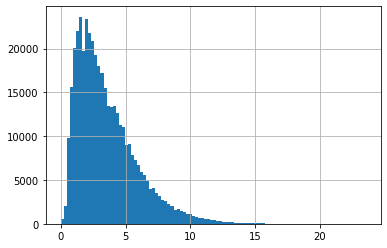

In [9]:
df['max. wv (m/s)'].hist(bins=100)

In [10]:
df['max. wv (m/s)'].min(), df['max. wv (m/s)'].max(), 

(0.0, 23.5)

In [11]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))

In [12]:
train_split, df.shape

(294315, (420451, 15))

In [18]:
df = df[df.columns[1:]]

In [19]:
# Apply normalization on ALL data, but using only TRAINING data
data_mean = df[:train_split].mean(axis=0)
data_std = df[:train_split].std(axis=0)

# standard normalize
df = (df-data_mean) / data_std

In [24]:
# train_test
train_data = df.loc[:train_split-1]
val_data = df.loc[train_split:]

In [26]:
from tensorflow.keras.utils import timeseries_dataset_from_array

In [30]:
step = 6
past = 720
future = 72
patience = 3
batch_size = 256

start = past + future
end = start + train_split

# start, end
x_train = train_data.values
y_train = df.iloc[start:end]['T (degC)']
display(y_train.head())

sequence_length = int(past / step)

792   -2.723068
793   -2.679158
794   -2.619070
795   -2.575160
796   -2.487339
Name: T (degC), dtype: float64

In [36]:
print('X_train shape ==', x_train.shape)
print('y_train shape ==', y_train.shape)

X_train shape == (294315, 14)
y_train shape == (294315,)


In [37]:
dataset_train = timeseries_dataset_from_array(x_train, 
                                              y_train,
                                              sequence_length=sequence_length,
                                              sampling_rate=step,
                                              batch_size=batch_size)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

2021-08-27 17:52:19.967109: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Input shape: (256, 120, 14)
Target shape: (256,)


2021-08-27 17:52:20.361370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [38]:
x_end = len(val_data) - past - future
y_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = df.iloc[y_start:]['T (degC)']

dataset_val = timeseries_dataset_from_array(x_val, y_val,
                                            sequence_length=sequence_length,
                                            sampling_rate=step,
                                            batch_size=batch_size,)

# Model

In [48]:
import gctf

from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

ImportError: cannot import name 'Adam' from 'keras.optimizers' (/Users/valdirsalustino/Documents/git/keras-forecasting/venv/lib/python3.9/site-packages/keras/optimizers.py)